In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Flatten, Convolution2D, MaxPooling2D, Dropout

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC

from Models import Models, PretrainedModels

In [2]:
import random

random.seed(10)

# Carga de datos

In [3]:
train_data = pd.read_csv("data/asl/train.csv")
test_data = pd.read_csv("data/asl/validation.csv")

In [4]:
train_data.head()

,sequence_id,target,file
0,1,yes,/Users/andreaamaya/Trabajo/megaproyecto_model/...
1,1,yes,/Users/andreaamaya/Trabajo/megaproyecto_model/...
2,1,yes,/Users/andreaamaya/Trabajo/megaproyecto_model/...
3,1,yes,/Users/andreaamaya/Trabajo/megaproyecto_model/...
4,1,yes,/Users/andreaamaya/Trabajo/megaproyecto_model/...


# Analisis Exploratorio

In [5]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
train_letters = list(train_data.target.unique())
train_letters.sort()
print(f"Frases unicas : {train_letters}")

--------------------Train data--------------------
Cantidad de filas : 12810
Frases unicas : ['bathroom', 'cat', 'dog', 'eat food', 'father', 'fine', 'finish', 'go to', 'hello', 'help', 'learn', 'like', 'me', 'milk', 'more', 'mother', 'no', 'please', 'repeat', 'see you later', 'sign', 'thank you', 'want', 'what', 'yes']


In [6]:
print("--------------------Test data--------------------")
print(f"Cantidad de filas : {test_data.shape[0]}")
test_letters = list(test_data.target.unique())
test_letters.sort()
print(f"Frases unicas : {test_letters}")

--------------------Test data--------------------
Cantidad de filas : 2580
Frases unicas : ['bathroom', 'cat', 'dog', 'eat food', 'father', 'fine', 'finish', 'go to', 'hello', 'help', 'learn', 'like', 'me', 'milk', 'more', 'mother', 'no', 'please', 'repeat', 'see you later', 'sign', 'thank you', 'want', 'what', 'yes']


In [7]:
if (test_letters != train_letters):
    raise ValueError("Error between target and train")

In [8]:
train_data.describe()

,sequence_id
count,12810.000000
mean,214.000000
std,123.268756
min,1.000000
25%,107.000000
50%,214.000000
75%,321.000000
max,427.000000


# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [9]:
def get_needed_cols():
    cols = []

    for i in range(21):
        cols.append(f'x_Right_hand_{i}')
        cols.append(f'y_Right_hand_{i}')
        cols.append(f'x_Left_hand_{i}')
        cols.append(f'y_Left_hand_{i}')
    
    return cols

In [10]:
df = pd.read_csv("data/asl/data.csv")
df_test = df[df['sequence_id'].isin(test_data['sequence_id'])]
df_train = df[df['sequence_id'].isin(train_data['sequence_id'])]

In [11]:
print(len(df))
print(len(df_test) == len(test_data))
print(len(df_train) == len(train_data))

15390
True
True


# Modelo

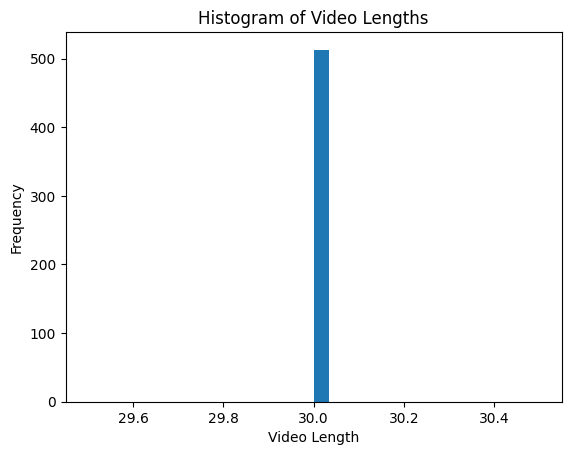

In [12]:
# Compute the lengths of the video sequences
video_lengths = df.groupby('sequence_id').size()
max_seq_length = video_lengths.max()
# max_seq_length = 30
# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [13]:
video_lengths.max()

30

In [14]:
# Create a one-hot encoder
label_encoder = LabelEncoder()

In [15]:
def padding_labels(target):
    integer_encoded = label_encoder.fit_transform(target)
    integer_encoded = integer_encoded.reshape(-1, 1)

    # Encode the word "Hello"
    onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to get a numpy array as output
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [16]:
target_train = df_train['target'][df_train.groupby('sequence_id').cumcount() == 0].tolist()

In [17]:
X_train = df_train
y_train = padding_labels(target_train)

/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
del X_train["sequence_id"] 
del X_train["target"] 

print(len(X_train), len(y_train))

12810 427


In [19]:
target_test = df_test['target'][df_test.groupby('sequence_id').cumcount() == 0].tolist()

In [20]:
X_test = df_test
y_test = padding_labels(target_test)

/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
del X_test["sequence_id"] 
del X_test["target"] 

print(len(X_test), len(y_test))

2580 86


In [22]:
len(y_train) + len(y_test) == len(df["sequence_id"].unique())

True

In [23]:
models = Models()

In [24]:
X_test_flat = models.get_flat_X(X_test)

In [25]:
X_test = models.get_three_dimensions(X_test)

In [26]:
X_train_flat = models.get_flat_X(X_train)

In [27]:
X_train = models.get_three_dimensions(X_train)

In [28]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (427, 30, 84) (427, 25)
Test: (86, 30, 84) (86, 25)


# Modelo
La entrada son las coordenadas de las manos. Cada video cuenta con n cantidad de filas, 84 columnas (21 columnas por cada coordenada y por ambas manos).
La salida es la frase. La frase se representa por un entero que da el one hot encoder.

Se usa convoluciones para resaltar las caracteristicas en la entrada. Debido a que la entrada son coordenadas normalizadas de un video, se supone que funciona igual que si la entrada fuera una imagen. Estas redes extraen caracteristicas de forma automatica para clasificar objetos luego. Al buscar patrones, se espera que pueda predecir un video que ya ha sido entrenado previamente.

Se reduce el tamaño de la entrada haciendo uso de max pooling y flatten.

Se hace uso de Dense para conectar entradas con salidas.

Se hace uso de Dropout para evitar el sobreajuste.

Relu elimina negativos. 
Sigmoid nos ayuda a obtener la probabilidad de que un ejemplo pertenezca a la clase positiva.
Softmax hace clasificacion multiclase (en nuestro caso las palabras a predecir).

In [29]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(target_train),
                                        y = target_train                                                    
                                    )
class_weights = dict(zip(np.unique(target_train), class_weights))

In [30]:
cnn_model = Sequential()
cnn_model.add(Convolution2D(128, (3, 3), padding="same", input_shape=(max_seq_length, models.num_features, 1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# cnn_model.add(Convolution2D(64, (3, 3), activation='relu'))
# cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# cnn_model.add(Convolution2D(128, (3, 3), activation='relu'))
# cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


cnn_model.add(Convolution2D(256, (3, 3), padding="same", activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))


cnn_model.add(Flatten())

cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(len(y_train[1]), activation='softmax'))

In [31]:
# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))
# Get the predictions from the model
y_pred_cnn = cnn_model.predict(X_test)# Find the most likely prediction for each sample

most_likely_predictions = np.argmax(y_pred_cnn, axis=1)
cnn_test_pred = label_encoder.inverse_transform(most_likely_predictions)

test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/50
54/54 [==============================] - 3s 55ms/step - loss: 3.0270 - accuracy: 0.0960 - val_loss: 2.8392 - val_accuracy: 0.0930
Epoch 2/50
54/54 [==============================] - 3s 51ms/step - loss: 2.1203 - accuracy: 0.3443 - val_loss: 1.8505 - val_accuracy: 0.5581
Epoch 3/50
54/54 [==============================] - 3s 52ms/step - loss: 1.0045 - accuracy: 0.6745 - val_loss: 1.4584 - val_accuracy: 0.6395
Epoch 4/50
54/54 [==============================] - 3s 51ms/step - loss: 0.6274 - accuracy: 0.8033 - val_loss: 1.5256 - val_accuracy: 0.6279
Epoch 5/50
54/54 [==============================] - 3s 56ms/step - loss: 0.3665 - accuracy: 0.8876 - val_loss: 1.7326 - val_accuracy: 0.6163
Epoch 6/50
54/54 [==============================] - 3s 51ms/step - loss: 0.2798 - accuracy: 0.9040 - val_loss: 1.5884 - val_accuracy: 0.6860
Epoch 7/50
54/54 [==============================] - 3s 53ms/step - loss: 0.2301 - accuracy: 0.9297 - val_loss: 1.7230 - val_accuracy: 0.6512
Epoch 8/50
54

In [32]:
# from sklearn.model_selection import GridSearchCV

# # Create the Decision Tree classifier
# dt_classifier = DecisionTreeClassifier()

# # Define the hyperparameters and their possible values
# param_grid = {
#     'base_estimator__max_depth': [len(test_letters) - 1],
#     'base_estimator__min_samples_split': [2, 5, 10],
#     'base_estimator__min_samples_leaf': [1, 2, 4],
#     'base_estimator__max_features': [None, 'auto', 'sqrt', 'log2'],
#     'base_estimator__criterion': ['gini', 'entropy']
# }

# adaboost_model = AdaBoostClassifier(dt_classifier, n_estimators=50, random_state=42)
# # Perform a grid search with cross-validation
# grid_search = GridSearchCV(adaboost_model, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train_flat, target_train)

# # Print the best hyperparameters
# print("Best Decision Tree Hyperparameters:", grid_search.best_params_)
# # Get the best AdaBoost model with the tuned Decision Tree
# best_adaboost_model = grid_search.best_estimator_

# # Evaluate the model on the test set
# accuracy = best_adaboost_model.score(X_test_flat, target_test)
# print("Accuracy on Test Set:", accuracy)

/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/andreaamaya/Library/Python/3.9/lib/p

Best Decision Tree Hyperparameters: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 24, 'base_estimator__max_features': 'sqrt', 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 5}
Accuracy on Test Set: 0.6976744186046512


In [ ]:
# Create the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Define the hyperparameters and their possible values
param_grid = {
    'base_estimator__max_depth': [len(test_letters) - 1],
    'base_estimator__min_samples_split': [13, 15, 18],
    'base_estimator__min_samples_leaf': [1],
    'base_estimator__max_features': [None],
    'base_estimator__criterion': ['entropy']
}

adaboost_model = AdaBoostClassifier(dt_classifier, n_estimators=50, random_state=42)
# Perform a grid search with cross-validation
grid_search = GridSearchCV(adaboost_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_flat, target_train)

# Print the best hyperparameters
print("Best Decision Tree Hyperparameters:", grid_search.best_params_)
# Get the best AdaBoost model with the tuned Decision Tree
best_adaboost_model = grid_search.best_estimator_

# Evaluate the model on the test set
accuracy = best_adaboost_model.score(X_test_flat, target_test)
print("Accuracy on Test Set:", accuracy)

In [32]:
# Create the Decision Tree classifier
base_model = DecisionTreeClassifier(
    min_samples_leaf=1, min_samples_split=5, max_depth=len(test_letters) - 1, criterion="entropy", max_features='sqrt'
)
decision_tree = AdaBoostClassifier(
    base_model, n_estimators=300, random_state=42,
    )
decision_tree.fit(X_train_flat, target_train)

# Make predictions
y_pred_tree = decision_tree.predict(X_test_flat)

# Calculate the accuracy score on a test dataset
accuracy_tree = decision_tree.score(X_test_flat, target_test)

# Print the accuracy
print(f'Accuracy: {accuracy_tree:.2f}')

Accuracy: 0.73


In [33]:
# Create an SVC classifier
svm_classifier = SVC(C=1, kernel="linear", gamma=0.001, class_weight=class_weights)
# Fit the grid search to your training data
svm_classifier.fit(X_train_flat, target_train)
# Evaluate the model on the test data
y_pred_svm = svm_classifier.predict(X_test_flat)

# Calculate the accuracy score on a test dataset
accuracy_svm = svm_classifier.score(X_test_flat, target_test)

# Print the accuracy
print(f'Accuracy: {accuracy_svm:.2f}')

Accuracy: 0.56


# Guardando los modelos

In [34]:
cnn_model.save('cnn_asl')
models.save_model("tree_asl", decision_tree)
models.save_model("svm_asl", svm_classifier)

INFO:tensorflow:Assets written to: cnn_asl/assets


INFO:tensorflow:Assets written to: cnn_asl/assets


In [35]:
models.save_model("label_encoder_asl", label_encoder)

# Usando los tres modelos

In [36]:
pretainedModels = PretrainedModels(is_asl=True)
results = pretainedModels.get_predictions(df_test)
results = pretainedModels.get_unique_pred()

1/1 [==============================] - 0s 13ms/step


In [37]:
correct = 0
for i in range(len(target_test)):
    if (target_test[i] in results[i]):
        correct += 1
    else:
        print(">>> LOG INCORRECTA: ")
        print("            Predicho: ", results[i])
        print("            Correcto: ", target_test[i])


>>> LOG INCORRECTA: 
            Predicho:  ['dog', 'yes']
            Correcto:  see you later
>>> LOG INCORRECTA: 
            Predicho:  ['finish', 'learn']
            Correcto:  sign
>>> LOG INCORRECTA: 
            Predicho:  ['sign']
            Correcto:  what
>>> LOG INCORRECTA: 
            Predicho:  ['repeat', 'sign', 'please']
            Correcto:  help
>>> LOG INCORRECTA: 
            Predicho:  ['no', 'milk']
            Correcto:  see you later
>>> LOG INCORRECTA: 
            Predicho:  ['sign', 'learn']
            Correcto:  repeat
>>> LOG INCORRECTA: 
            Predicho:  ['finish', 'learn']
            Correcto:  more
>>> LOG INCORRECTA: 
            Predicho:  ['finish', 'bathroom', 'learn']
            Correcto:  sign
>>> LOG INCORRECTA: 
            Predicho:  ['want', 'sign']
            Correcto:  what
>>> LOG INCORRECTA: 
            Predicho:  ['sign', 'learn']
            Correcto:  repeat
>>> LOG INCORRECTA: 
            Predicho:  ['finish', 'learn']
 

In [38]:
print("Correct >> ", correct)
print("Incorrect >> ", len(target_test)-correct)
print("Ratio >> ", str(correct/len(target_test)))

Correct >>  72
Incorrect >>  14
Ratio >>  0.8372093023255814


# Reutilizando los tres modelos

In [39]:
load_test_data = pd.read_csv("data/asl/data_tests.csv")
load_test_data.head()

,sequence_id,target,file,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,...,x_Right_hand_16,y_Right_hand_16,x_Right_hand_17,y_Right_hand_17,x_Right_hand_18,y_Right_hand_18,x_Right_hand_19,y_Right_hand_19,x_Right_hand_20,y_Right_hand_20
0,1,2_sign,/Users/andreaamaya/Trabajo/megaproyecto_model/...,0.779944,0.857275,0.527943,0.674595,0.338587,0.450659,0.242364,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2_sign,/Users/andreaamaya/Trabajo/megaproyecto_model/...,1.000000,0.105118,0.738827,0.019696,0.554572,0.011717,0.435643,...,0.146080,0.462339,0.009484,0.677178,0.062564,0.199427,0.016843,0.299629,0.000000,0.464140
2,1,2_sign,/Users/andreaamaya/Trabajo/megaproyecto_model/...,1.000000,0.049991,0.772897,0.000000,0.591776,0.041368,0.466249,...,0.301188,0.352286,0.299280,0.947524,0.340257,0.324660,0.261477,0.309198,0.221117,0.485982
3,1,2_sign,/Users/andreaamaya/Trabajo/megaproyecto_model/...,1.000000,0.060846,0.767145,0.000000,0.569186,0.068999,0.435114,...,0.297766,0.299877,0.327299,0.965769,0.358205,0.424474,0.283723,0.333584,0.243731,0.450707
4,1,2_sign,/Users/andreaamaya/Trabajo/megaproyecto_model/...,1.000000,0.016505,0.763875,0.000000,0.550771,0.109922,0.404051,...,0.293271,0.324966,0.339481,1.000000,0.368824,0.479093,0.292869,0.368690,0.246684,0.459646


In [40]:
target = load_test_data["target"] 

In [41]:
del load_test_data["sequence_id"] 
del load_test_data["target"] 
del load_test_data["file"] 

In [43]:
pretainedModels = PretrainedModels(is_asl=True)
results = pretainedModels.get_predictions(load_test_data)

1/1 [==============================] - 0s 15ms/step


In [44]:
expected = target.unique()
expected

array(['2_sign', '3_like', '13_see you later', '11_father', '14_hello',
       '6_thank you', '4_bathroom', '7_please', '9_no', '12_me', '10_yes',
       '8_help', '5_eat food', '1_finish'], dtype=object)

In [45]:
results = pretainedModels.get_unique_pred()
results

[['go to', 'learn'],
 ['like'],
 ['see you later'],
 ['fine'],
 ['hello'],
 ['thank you'],
 ['bathroom'],
 ['please'],
 ['no', 'milk', 'fine'],
 ['me'],
 ['yes'],
 ['want', 'repeat', 'learn'],
 ['eat food'],
 ['dog', 'sign']]

In [46]:
correct = 0
for i in range(len(results)):
    if (expected[i].split("_")[1] in results[i]):
        correct += 1
    else:
        print(f'Palabras incorrecta: {expected[i].split("_")[1]} predijo {results[i]}')

Palabras incorrecta: sign predijo ['go to', 'learn']
Palabras incorrecta: father predijo ['fine']
Palabras incorrecta: help predijo ['want', 'repeat', 'learn']
Palabras incorrecta: finish predijo ['dog', 'sign']


In [47]:
print(f'Palabras correctas: {correct} de {len(results)}')

Palabras correctas: 10 de 14
